# FIAP Bootcamp - Wtec Suprimentos - Sugestão de Limite
Case: **Wtec Suprimentos - Análise de Crédito**\
Turma: **1IAR**

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Claudio Manuel           | RM 346353      | 1IAR |
| Jonas Zarpellon          | RM 345724      | 1IAR |
| Rafael Yuji              | RM 346108      | 1IAR |

## Introdução

### Problema Proposto - Parte 4-B: Sugestão de Limite de Crédito
- A empresa deseja, entre outras coisas, criar um 'robö automatizado' (na linguagem da propria empresa), que realize uma recomendacäo de crédito para que os analistas se baseiem nessa recomendacäo para conceder o limite måximo de crédito.
- Vale salientar que por se tratar de valores monetérios é importante que este modelo tenha um bom desempenho

### Abordagem Proposta
- O objetivo desta modelagem é treinar um algoritmo de aprendizado capaz de sugerir um limite de crédito para um cliente
- Será utilizado um algoritmo supervisionado para essa regressão, baseado nos limites atribuidos aos clientes na base de dados histórica
- Será explorada somente a hipótese 2, utilizando as informações disponíveis nas documentações contábeis

### Setup

In [1]:
# dados / io
import pandas as pd
import pandas_flavor as pf
import numpy as np
import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# otimização
from sklearnex import patch_sklearn
patch_sklearn()
# preprocessamento
from sklearn.preprocessing import MinMaxScaler
# machine learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from xgboost import XGBRegressor
# seleção de modelos
import optuna as opt
opt.logging.set_verbosity(opt.logging.WARNING)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    r2_score, mean_absolute_percentage_error, median_absolute_error, \
    mean_gamma_deviance
from sklearn.inspection import permutation_importance
# display
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=opt.exceptions.ExperimentalWarning)
pd.options.display.float_format = '{:,.4f}'.format


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Carga de Dados

In [2]:
data = pd.read_csv('solicitacoescredito_segmentada.csv')
data.sample(10).T

,3730,5130,6145,7485,2359,8852,6865,6571,2063,1442
numero_solicitacao,"3,803.0000","5,203.0000","6,218.0000","7,558.0000","2,432.0000","8,925.0000","6,938.0000","6,644.0000","2,136.0000","1,485.0000"
razaoSocial,Julia Anderson,Tina Knowles,Jill Rowley-Brown,Martyn James,Ashleigh Allen-Ahmed,Molly Gordon,Lisa Parker,Dr. Donald White,Bethany Fowler-Jenkins,Thomas Shaw-Graham
nomeFantasia,Antony Mitchell,Mathew Gibson,Dr. Justin Robertson,Diane Moore,Laura Shaw-Turner,Colin Butcher,Carole Pickering,Timothy Shaw,Ms. Leanne Harrison,Lawrence Moore
cnpjSemTraco,HJOD61946164590057,KRST28775610809302,DZHB34514257528631,CPDV38132357851268,OQTP06350836010371,SAYU61634344280679,ARLG39955776479526,TRAD39089840050862,GIIY27130050665364,BZWY87027262551553
maiorAtraso,8,2,0,32,7,43,4,22,0,4
margemBrutaAcumulada,0.3897,0.4570,0.6286,0.0000,0.0000,0.4313,0.4673,0.3210,0.4145,0.0992
percentualProtestos,0.0000,0.0000,0.0000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000
primeiraCompra,2012-06-05T00:00:00,2019-08-26T00:00:00,2020-05-27T00:00:00,2015-07-24T11:39:09,2010-04-22T15:18:40,2013-02-15T00:00:00,2015-03-11T00:00:00,2016-07-05T00:00:00,2019-11-08T00:00:00,2017-01-19T00:00:00
prazoMedioRecebimentoVendas,41,0,0,0,0,31,52,31,0,0
titulosEmAberto,"20,966.6300",0.0000,"2,640.0000",0.0000,0.0000,"8,228.3600","351,900.0000","15,476.5000",0.0000,0.0000


### Pre-Processamento

#### filtro

In [3]:
# filtra as solicitações aprovadas
@pf.register_dataframe_method
def filter_status(
	data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X = X[X.status.isin(['AprovadoAnalista', 'AprovadoComite'])]
	X = X[X.anoFundacao > 1900]
	X = X[X.faturamentoBruto > 0]
	X = X[X.valorAprovado > 0]
	X = X[X.periodoDemonstrativoEmMeses > 0]
	X = X[X.cluster1.notna()]
	return X
data.filter_status().describe().T

,count,mean,std,min,25%,50%,75%,max
numero_solicitacao,"6,627.0000","4,758.5695","2,538.1402",1.0000,"2,678.0000","4,853.0000","6,946.5000","9,034.0000"
maiorAtraso,"6,627.0000",23.9031,63.8556,0.0000,3.0000,6.0000,21.0000,977.0000
margemBrutaAcumulada,"6,627.0000",0.3734,0.1950,0.0000,0.2992,0.4123,0.5123,1.0000
percentualProtestos,"5,642.0000",0.0155,0.5807,0.0000,0.0000,0.0000,0.0000,36.9837
prazoMedioRecebimentoVendas,"6,627.0000",23.5636,65.7522,0.0000,0.0000,0.0000,32.0000,"1,605.0000"
titulosEmAberto,"6,627.0000","52,004.6309","186,453.5425",0.0000,0.0000,0.0000,"17,352.2400","2,836,656.0000"
valorSolicitado,"6,627.0000","272,188.0506","7,382,539.2892","3,000.0000","25,000.0000","50,000.0000","100,000.0000","600,000,000.0000"
diferencaPercentualRisco,"6,627.0000",0.7411,0.1251,0.2642,0.6604,0.7500,0.8491,1.0000
percentualRisco,"6,627.0000",0.2589,0.1251,0.0000,0.1509,0.2500,0.3396,0.7358
dashboardCorrelacao,"6,627.0000",0.0427,0.4915,-1.0000,0.0000,0.0000,0.0000,0.9999


#### feature engineering

In [4]:
# gera as features calculadas sem usar as colunas de documentação
@pf.register_dataframe_method
def engineer(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	X['faturamentoMensal'] = X.faturamentoBruto / X.periodoDemonstrativoEmMeses
	X['margemMensal'] = X.margemBruta / X.periodoDemonstrativoEmMeses
	X['margem_percentual'] = (X.margemMensal / X.faturamentoMensal).replace([np.inf, np.NINF], np.nan)
	X['dt_dataAprovadoNivelAnalista'] = pd.to_datetime(X.dataAprovadoNivelAnalista, errors='coerce')
	X['dt_primeiraCompra'] = pd.to_datetime(X.primeiraCompra, errors='coerce')
	X['tempoPrimeiraCompra'] = (X.dt_dataAprovadoNivelAnalista - X.dt_primeiraCompra).dt.days
	return X

data.filter_status().engineer().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   numero_solicitacao            6627 non-null   float64       
 1   razaoSocial                   6627 non-null   object        
 2   nomeFantasia                  6627 non-null   object        
 3   cnpjSemTraco                  6627 non-null   object        
 4   maiorAtraso                   6627 non-null   int64         
 5   margemBrutaAcumulada          6627 non-null   float64       
 6   percentualProtestos           5642 non-null   float64       
 7   primeiraCompra                6627 non-null   object        
 8   prazoMedioRecebimentoVendas   6627 non-null   int64         
 9   titulosEmAberto               6627 non-null   float64       
 10  valorSolicitado               6627 non-null   float64       
 11  status                        

#### seleção de features

In [5]:
# seleciona as features relevantes
@pf.register_dataframe_method
def select(
  data: pd.DataFrame,
  identifier: bool = False,
) -> pd.DataFrame:
	X = data.copy()
	keep = [
			'percentualRisco',
			'valorAprovado',
			# 'limiteEmpresaAnaliseCredito',
			'faturamentoMensal',
			'anoFundacao',
			'restricoes',
			'empresa_MeEppMei',
			'scorePontualidade',
			'margem_percentual',
			'maiorAtraso',
			'prazo_medio_cobranca',
			'tempoPrimeiraCompra',
			'prazoMedioRecebimentoVendas',
			'titulosEmAberto',
			'cluster1',
		]
	if identifier:
		keep = keep + ['numero_solicitacao']
	intersection = list(set(data.columns).intersection(set(keep)))
	return X[intersection]
data.filter_status().engineer().select().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tempoPrimeiraCompra          6627 non-null   int64  
 1   cluster1                     6627 non-null   float64
 2   prazoMedioRecebimentoVendas  6627 non-null   int64  
 3   anoFundacao                  6627 non-null   float64
 4   maiorAtraso                  6627 non-null   int64  
 5   faturamentoMensal            6627 non-null   float64
 6   valorAprovado                6627 non-null   float64
 7   scorePontualidade            6627 non-null   float64
 8   margem_percentual            6627 non-null   float64
 9   restricoes                   6627 non-null   object 
 10  percentualRisco              6627 non-null   float64
 11  empresa_MeEppMei             6627 non-null   object 
 12  titulosEmAberto              6627 non-null   float64
dtypes: float64(8), int

#### remoção de outliers

In [6]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

@pf.register_dataframe_method
def remove_outliers(
        data: pd.DataFrame,
    ) -> pd.DataFrame:    
    X = data.copy()
    # gera uma copia nao modificada dos dados
    Z = X.copy()
    # treina um modelo de Isolation Forest
    model_if = IsolationForest(contamination=0.05).fit(Z)    
    X['outlier_if'] = model_if.predict(Z)
    # treina um modelo Local Outlier Factor
    model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  
    X['outlier_lof'] = model_lof.fit_predict(Z)
    # treina um modelo One Class SVM   
    model_ocsvm = OneClassSVM(nu=0.05).fit(Z)
    X['outlier_ocsvm'] = model_ocsvm.predict(Z)
    # treina um modelo de Robust Covariance
    model_rc = EllipticEnvelope(contamination=0.05).fit(Z)
    X['outlier_rc'] = model_rc.predict(Z)
    # remove os outliers
    X = X[X.outlier_if != -1]
    X = X[X.outlier_lof != -1]
    X = X[X.outlier_ocsvm != -1]
    X = X[X.outlier_rc != -1]
    X = X.drop(columns = ['outlier_if', 'outlier_lof', 'outlier_ocsvm', 'outlier_rc'])
    return X
d = data.filter_status().engineer().select().remove_outliers()
print (f'Outliers removidos: {d.shape[0] - d.remove_outliers().shape[0]}')


c:\Users\jonas\miniconda3\envs\edge\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (83.224137027264462 > 82.279390476974854). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\Users\jonas\miniconda3\envs\edge\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (74.198091348637462 > 70.046701758317553). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(


Outliers removidos: 783


#### encoding das categorias

In [7]:
# realiza o one-hot encoding do cluster
@pf.register_dataframe_method
def encode(
		data: pd.DataFrame,
		features: list,
		) -> pd.DataFrame:
	X = data.copy()
	for feature in features:
		X = pd.get_dummies(X[feature], prefix=feature).join(X)
		X = X.drop(columns=[feature])
	return X
data.filter_status().engineer().select().encode(['cluster1']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster1_0.0                 6627 non-null   uint8  
 1   cluster1_1.0                 6627 non-null   uint8  
 2   cluster1_2.0                 6627 non-null   uint8  
 3   cluster1_3.0                 6627 non-null   uint8  
 4   cluster1_4.0                 6627 non-null   uint8  
 5   cluster1_5.0                 6627 non-null   uint8  
 6   tempoPrimeiraCompra          6627 non-null   int64  
 7   prazoMedioRecebimentoVendas  6627 non-null   int64  
 8   anoFundacao                  6627 non-null   float64
 9   maiorAtraso                  6627 non-null   int64  
 10  faturamentoMensal            6627 non-null   float64
 11  valorAprovado                6627 non-null   float64
 12  scorePontualidade            6627 non-null   float64
 13  margem_percentual 

#### data types

In [8]:
# converte data types
@pf.register_dataframe_method
def type_cast(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	for col in X.columns:
		if col in ['cluster1', 'cluster2']:
			X[col] = X[col].astype('int32', errors='ignore')
		else:
			X[col] = X[col].astype('float32')		
	return X
data.filter_status().engineer().select().encode(['cluster1']).type_cast().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster1_0.0                 6627 non-null   float32
 1   cluster1_1.0                 6627 non-null   float32
 2   cluster1_2.0                 6627 non-null   float32
 3   cluster1_3.0                 6627 non-null   float32
 4   cluster1_4.0                 6627 non-null   float32
 5   cluster1_5.0                 6627 non-null   float32
 6   tempoPrimeiraCompra          6627 non-null   float32
 7   prazoMedioRecebimentoVendas  6627 non-null   float32
 8   anoFundacao                  6627 non-null   float32
 9   maiorAtraso                  6627 non-null   float32
 10  faturamentoMensal            6627 non-null   float32
 11  valorAprovado                6627 non-null   float32
 12  scorePontualidade            6627 non-null   float32
 13  margem_percentual 

#### limpeza

In [9]:
# elimina valores nulos
@pf.register_dataframe_method
def clean(
  data: pd.DataFrame,
) -> pd.DataFrame:
	return data.dropna()
data.filter_status().engineer().select().encode(['cluster1']).type_cast().clean().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 8961
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster1_0.0                 6627 non-null   float32
 1   cluster1_1.0                 6627 non-null   float32
 2   cluster1_2.0                 6627 non-null   float32
 3   cluster1_3.0                 6627 non-null   float32
 4   cluster1_4.0                 6627 non-null   float32
 5   cluster1_5.0                 6627 non-null   float32
 6   tempoPrimeiraCompra          6627 non-null   float32
 7   prazoMedioRecebimentoVendas  6627 non-null   float32
 8   anoFundacao                  6627 non-null   float32
 9   maiorAtraso                  6627 non-null   float32
 10  faturamentoMensal            6627 non-null   float32
 11  valorAprovado                6627 non-null   float32
 12  scorePontualidade            6627 non-null   float32
 13  margem_percentual 

#### padronização

In [10]:
# aplica padronização por z-score
@pf.register_dataframe_method
def standardize(
		data: pd.DataFrame,
	) -> pd.DataFrame:
	X = data.copy()
	# clip outliers
	# X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)
	standardizer = MinMaxScaler(feature_range = (0, 1))
	X = pd.DataFrame(standardizer.fit_transform(X), columns=X.columns)
	return X
data.filter_status().engineer().select().encode(['cluster1']).type_cast().clean().standardize().describe().T

,count,mean,std,min,25%,50%,75%,max
cluster1_0.0,"6,627.0000",0.1462,0.3534,0.0000,0.0000,0.0000,0.0000,1.0000
cluster1_1.0,"6,627.0000",0.1364,0.3433,0.0000,0.0000,0.0000,0.0000,1.0000
cluster1_2.0,"6,627.0000",0.3730,0.4836,0.0000,0.0000,0.0000,1.0000,1.0000
cluster1_3.0,"6,627.0000",0.0155,0.1237,0.0000,0.0000,0.0000,0.0000,1.0000
cluster1_4.0,"6,627.0000",0.2801,0.4491,0.0000,0.0000,0.0000,1.0000,1.0000
cluster1_5.0,"6,627.0000",0.0487,0.2153,0.0000,0.0000,0.0000,0.0000,1.0000
tempoPrimeiraCompra,"6,627.0000",0.3336,0.2630,0.0000,0.1287,0.2514,0.4883,1.0000
prazoMedioRecebimentoVendas,"6,627.0000",0.0147,0.0410,0.0000,0.0000,0.0000,0.0199,1.0000
anoFundacao,"6,627.0000",0.8219,0.1439,0.0000,0.7436,0.8590,0.9359,1.0000
maiorAtraso,"6,627.0000",0.0245,0.0654,0.0000,0.0031,0.0061,0.0215,1.0000


#### preparação dos dados

In [11]:
data_preprocess = data.filter_status().engineer().select().remove_outliers().encode(['cluster1']).type_cast().clean()
targets_preprocess = data_preprocess['valorAprovado']
features_preprocess = data_preprocess.drop(columns=['valorAprovado']).standardize()

data_train, data_test, targets_train, targets_test = train_test_split(features_preprocess, targets_preprocess, test_size=0.2, random_state=42)

display(data_train.info())
display(data_train.describe().T)
print (f'Shape de data_train: {data_train.shape}')
print (f'Shape de data_test: {data_test.shape}')

c:\Users\jonas\miniconda3\envs\edge\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (73.926115789487795 > 68.913413740871391). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\Users\jonas\miniconda3\envs\edge\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (70.484541652188668 > 40.201217679552236). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\Users\jonas\miniconda3\envs\edge\lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (70.417643423075049 > 42.224948391044663). You may want to try with a higher value of support_fraction (current value: 0.501

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 387 to 860
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cluster1_0.0                 4619 non-null   float32
 1   cluster1_1.0                 4619 non-null   float32
 2   cluster1_2.0                 4619 non-null   float32
 3   cluster1_4.0                 4619 non-null   float32
 4   cluster1_5.0                 4619 non-null   float32
 5   tempoPrimeiraCompra          4619 non-null   float32
 6   prazoMedioRecebimentoVendas  4619 non-null   float32
 7   anoFundacao                  4619 non-null   float32
 8   maiorAtraso                  4619 non-null   float32
 9   faturamentoMensal            4619 non-null   float32
 10  scorePontualidade            4619 non-null   float32
 11  margem_percentual            4619 non-null   float32
 12  restricoes                   4619 non-null   float32
 13  percentualRisco  

None

,count,mean,std,min,25%,50%,75%,max
cluster1_0.0,"4,619.0000",0.1258,0.3316,0.0000,0.0000,0.0000,0.0000,1.0000
cluster1_1.0,"4,619.0000",0.1414,0.3484,0.0000,0.0000,0.0000,0.0000,1.0000
cluster1_2.0,"4,619.0000",0.4036,0.4907,0.0000,0.0000,0.0000,1.0000,1.0000
cluster1_4.0,"4,619.0000",0.2916,0.4546,0.0000,0.0000,0.0000,1.0000,1.0000
cluster1_5.0,"4,619.0000",0.0377,0.1904,0.0000,0.0000,0.0000,0.0000,1.0000
tempoPrimeiraCompra,"4,619.0000",0.3206,0.2578,0.0000,0.1217,0.2431,0.4758,0.9993
prazoMedioRecebimentoVendas,"4,619.0000",0.0530,0.1100,0.0000,0.0000,0.0000,0.0784,1.0000
anoFundacao,"4,619.0000",0.8248,0.1360,0.0000,0.7436,0.8590,0.9359,1.0000
maiorAtraso,"4,619.0000",0.0225,0.0615,0.0000,0.0031,0.0051,0.0205,1.0000
faturamentoMensal,"4,619.0000",0.0578,0.1229,0.0000,0.0051,0.0133,0.0460,1.0000


Shape de data_train: (4619, 16)
Shape de data_test: (1155, 16)


### Treinamento dos Modelos

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- foram testados 6 algoritmos <br>
- para cada algoritmo, foram testadas as principais variações dos seus hiperparâmetros<br>
- a busca foi feita por otimização bayesiana, utilizando validação cruzada com 5 partições <br>
- o particionamento do conjunto de validação foi feito com 20% dos registros disponíveis
</td></tr></table></div>

#### rotinas de otimização

In [12]:
# callback para salvar o melhor modelo
def callback(
		study: opt.study.Study,
		trial: opt.trial.FrozenTrial,
	) -> None:
	if study.best_trial.number == trial.number:
		study.set_user_attr(key='best_estimator', value=trial.user_attrs['estimator'])

In [13]:
# plota os resultados da otimização e a avaliação do melhor modelo no dataset de teste
def plot_optimization_results(
		study: opt.study.Study,
		y_test: pd.DataFrame,
		y_pred: np.ndarray,
	) -> None:

	# plota os resultados da otimização
	display(opt.visualization.plot_optimization_history(study))
	try:
		display(opt.visualization.plot_param_importances(study))
	except:
		...
	
	# imprime o melhor modelo
	print (f'Best trial: {study.best_trial.value}')
	print (f'Best parameters: {study.best_params}')

In [14]:
# rotina de otimização bayesiana
def optimize(
		objective, #Callable,
    description: str,
    n_trials: int,
		X: pd.DataFrame,
		y: pd.DataFrame,
		X_test: pd.DataFrame,
		y_test: pd.DataFrame,
	) -> dict: 
        
	# cria o estudo e executa a otimização
	study = opt.create_study(direction='maximize')
	study.optimize(lambda trial:objective(trial, X, y),
		callbacks=[callback], n_trials=n_trials, timeout=60*5, n_jobs=-1, show_progress_bar = True)

	# fita e salva o melhor modelo
	fit = study.user_attrs['best_estimator'].fit(X, y)
	joblib.dump(fit, f'models/{description}.joblib')

	# avalia os resultados no conjunto de teste
	y_pred_val = fit.predict(X)
	y_pred = fit.predict(X_test)

	p = pd.DataFrame(y_pred, columns=['y_pred'])
	p = p[p.y_pred <= 0]
	display(p)

	pv = pd.DataFrame(y_pred_val, columns=['y_pred_val'])
	pv = pv[pv.y_pred_val <= 0]
	display(pv)
	
	t = pd.DataFrame(y_test, columns=['y_test'])
	t = t[t.y_test <= 0]
	display(t)

	tv = pd.DataFrame(y, columns=['y'])
	tv = tv[tv.y <= 0]
	display(tv)

	metrics = {
		'validation': {
			'mae': mean_absolute_error(y, y_pred_val),
			'rmse': np.sqrt(mean_squared_error(y, y_pred_val)),
			'median_error': median_absolute_error(y, y_pred_val),
			'r2': r2_score(y, y_pred_val),
			'mape': mean_absolute_percentage_error(y, y_pred_val),
			'gamma_deviance': mean_gamma_deviance(y, y_pred_val),
		},
		'test': {
			'mae': mean_absolute_error(y_test, y_pred),
			'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
			'median_error': median_absolute_error(y, y_pred_val),
			'r2': r2_score(y_test, y_pred),
			'mape': mean_absolute_percentage_error(y_test, y_pred),
			'gamma_deviance': mean_gamma_deviance(y_test, y_pred),
		}
	}
	validation = pd.DataFrame(metrics['validation'], index=['validation'])
	test = pd.DataFrame(metrics['test'], index=['test'])
	display(pd.concat([validation, test], axis=0).T)

	# plota os resultados
	plot_optimization_results(study, y_test, y_pred)
	
	return {
		'description': description,
		'metrics': metrics,
		'estimator': fit,
		'results': study.trials_dataframe(),
		'predictions': y_pred,
	}

models = {}

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
foi utilizado o MAPE como métrica de avaliação, com o objetivo de minimizar o erro percentual com relação ao valor de referência, independente de sua escala
</td></tr></table></div>

#### árvore de regressão

In [15]:
# define o espaço de busca e a função objetivo
def objective_regression_tree(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = DecisionTreeRegressor(
		criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
		min_samples_split = trial.suggest_int('min_samples_split', 2, 100),
		min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
regression_tree_model = optimize(
	objective=objective_regression_tree, 
	description='regression_tree_risk', n_trials=300,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[regression_tree_model['description']] = regression_tree_model

  0%|          | 0/300 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"41,021.2676","43,099.8999"
rmse,"105,850.1567","102,567.1917"
median_error,"11,139.5349","11,139.5349"
r2,0.6218,0.6244
mape,0.9244,0.7284
gamma_deviance,0.3161,0.3637


Best trial: -0.42312854439187264
Best parameters: {'criterion': 'poisson', 'min_samples_split': 56, 'min_samples_leaf': 18}


#### random forest

In [16]:
# define o espaço de busca e a função objetivo
def objective_random_forests(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	estimator = RandomForestRegressor(
		criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
		min_samples_split = trial.suggest_int('min_samples_split', 2, 100),
		min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100),
	)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
random_forest_model = optimize(
	objective=objective_random_forests, 
	description='random_forests_risk', n_trials=100,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[random_forest_model['description']] = random_forest_model

  0%|          | 0/100 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"23,277.9308","33,004.7252"
rmse,"63,693.5643","79,155.8967"
median_error,"6,318.6839","6,318.6839"
r2,0.8631,0.7763
mape,0.8019,0.5648
gamma_deviance,0.1399,0.2489


Best trial: -0.3093037204413
Best parameters: {'criterion': 'poisson', 'min_samples_split': 5, 'min_samples_leaf': 4}


#### xgboost - dart

In [17]:
# define o espaço de busca e a função objetivo
def xgboost_regressor_dart(
		trial: opt.trial.Trial,
		X: pd.DataFrame,
		y: pd.DataFrame,
	) -> float:
	hyperparameters = {
		# 'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
		'booster': 'dart',
		'objective': 'reg:gamma',
		'eval_metric': 'mape',
		'verbosity': 0,
		'alpha': trial.suggest_float('alpha', 1e-1, 1.0, log=True),
		'lambda': trial.suggest_float('lambda', 1e-1, 1.0, log=True),
		'eta': trial.suggest_float('eta', 1e-10, 1.0, log=True),
		'max_depth': trial.suggest_int('max_depth', 1, 9),
		'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
		'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
		'gamma': trial.suggest_float('gamma', 1e-8, 1e8, log=True),
		'sample_type': trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
		'normalize_type': trial.suggest_categorical('normalize_type', ['tree', 'forest']),
		'rate_drop': trial.suggest_float('rate_drop', 1e-8, 1.0, log=True),
		'skip_drop': trial.suggest_float('skip_drop', 1e-8, 1.0, log=True),
		'updater': trial.suggest_categorical('updater', ['coord_descent', 'shotgun']),
		'feature_selector': trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle']),
	}
	hp = {
		'booster': hyperparameters['booster'],
		'objective': hyperparameters['objective'],
		'eval_metric': hyperparameters['eval_metric'],
		'verbosity': hyperparameters['verbosity'],
	}
	
	if hyperparameters['booster'] in ['gbtree', 'dart']:
		# L1 regularization term on weights. Increasing this value will make model more conservative.
		hp['alpha'] = hyperparameters['alpha']
		# L2 regularization term on weights. Increasing this value will make model more conservative.
		hp['lambda'] = hyperparameters['lambda']
		# Step size shrinkage used in update to prevents overfitting
		hp['eta'] = hyperparameters['eta']
		# maximum depth of the tree, signifies complexity of the tree.
		hp['max_depth'] = hyperparameters['max_depth']
		# Controls a way new nodes are added to the tree.
		hp['grow_policy'] = hyperparameters['grow_policy']
		# minimum child weight, larger the term more conservative the tree.
		hp['min_child_weight'] = hyperparameters['min_child_weight']
		# defines how conservative algorithm is.
		hp['gamma'] = hyperparameters['gamma']

	if hyperparameters['booster'] == 'dart':
		# sampling ratio for dropout.
		hp['sample_type'] = hyperparameters['sample_type']
		# Type of normalization algorithm
		hp['normalize_type'] = hyperparameters['normalize_type']
		# Dropout rate (a fraction of previous trees to drop during the dropout)
		hp['rate_drop'] = hyperparameters['rate_drop']
		# Probability of skipping the dropout procedure during a boosting iteration.
		hp['skip_drop'] = hyperparameters['skip_drop']

	if hyperparameters['booster'] == 'gblinear':
		# algorithm to fit linear model
		hp['updater'] = hyperparameters['updater']
		# feature selector
		hp['feature_selector'] = hyperparameters['feature_selector']

	estimator = XGBRegressor(**hp)
	trial.set_user_attr(key='estimator', value=estimator)
	score = cross_val_score(estimator, X, y, n_jobs=-1, cv=5, scoring='neg_mean_gamma_deviance')
	return score.mean()

np.seterr(divide='ignore', invalid='ignore')

# rotina de otimização bayesiana
xgboost_model_dart = optimize(
	objective=xgboost_regressor_dart, 
	description='xgboost_dart_risk', n_trials=200,
	X=data_train, y=targets_train, X_test=data_test, y_test=targets_test,)

models[xgboost_model_dart['description']] = xgboost_model_dart

  0%|          | 0/200 [00:00<?, ?it/s]

,y_pred


,y_pred_val


,y_test


,y


,validation,test
mae,"27,560.8887","32,985.0078"
rmse,"74,632.8047","82,988.5078"
median_error,"8,585.4570","8,585.4570"
r2,0.8120,0.7541
mape,0.6572,0.5124
gamma_deviance,0.1793,0.2683


Best trial: -0.32227109670639037
Best parameters: {'alpha': 0.13207001185507494, 'lambda': 0.3253058359867462, 'eta': 0.271374293466719, 'max_depth': 5, 'grow_policy': 'depthwise', 'min_child_weight': 2, 'gamma': 1.809955213942294e-07, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.011196872700373487, 'skip_drop': 0.1721151653603782, 'updater': 'shotgun', 'feature_selector': 'shuffle'}


#### rede neural MLP

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanRelativeError

In [19]:
# utiliza early stopping para parar o treinamento quando não houver mais melhora
# retorna o melhor modelo salvo pelo checkpoint
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=0.1,
    patience=200,
    verbose=0,
    restore_best_weights=True,
)

In [20]:
def hypermodel(hp):
	# implementa um modelo sequencial
	model = Sequential()
	# adiciona uma camada de entrada
	model.add(Input(shape=(data_train.shape[1])))
	# escala do modelo
	scale = hp.Int('scale', min_value=8, max_value=16, step=1)
	# profundidade do modelo
	depth = hp.Int('depth', min_value=2, max_value=4, step=1)
	# formato do modelo
	shape = hp.Choice('shape', ['linear', 'growing', 'shrinking'])
	# dropout 
	dropout = hp.Float('dropout', min_value=0.35, max_value=0.55, step=0.05)
	# calcula o numero total de neuronios
	total_neurons = scale * 1000
	# gera a distribuição de neuronios conforme o formato
	if shape == 'linear':
		neurons = [total_neurons // depth] * depth
	elif shape == 'shrinking':
		neurons = [int(total_neurons/2**(i+1)) for i in range(depth)]
	elif shape == 'growing':
		# reverse
		neurons = [int(total_neurons/2**(i+1)) for i in range(depth)]
		neurons.reverse()
	# adiciona as camadas ocultas
	for i in range(depth):
		model.add(Dense(neurons[i], activation='relu'))
		model.add(Dropout(dropout))
	# adiciona uma camada de saída
	model.add(Dense(1))
	# compila o modelo
	loss = 'mean_absolute_percentage_error'
	model.compile(
		# loss='mean_absolute_percentage_error',
		loss=loss,
		optimizer='adam',
		metrics=['mean_absolute_percentage_error', 'mean_squared_error', 'mean_absolute_error'])
	return model

In [23]:
optimizer = BayesianOptimization(
	hypermodel = hypermodel,
	objective = 'val_loss',
	max_trials = 50,
	executions_per_trial=1, 
	directory = 'search',	
	project_name = 'limite_risco_2',
	overwrite = True,
	num_initial_points = 10,
	beta = 2.6, 
)

optimizer.search_space_summary()

Search space summary
Default search space size: 4
scale (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 1, 'sampling': 'linear'}
depth (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
shape (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'growing', 'shrinking'], 'ordered': False}
dropout (Float)
{'default': 0.35, 'conditions': [], 'min_value': 0.35, 'max_value': 0.55, 'step': 0.05, 'sampling': 'linear'}


In [24]:
features_train_nn, features_val_nn, targets_train_nn, targets_val_nn = train_test_split(data_train, targets_train, test_size=0.2, random_state=42)

# realiza a busca
optimizer.search(
	features_train_nn,
	targets_train_nn,
  epochs=10000,
  batch_size=8000,
  validation_data=(features_val_nn, targets_val_nn),
  callbacks=[early_stopping],
  verbose=1,
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
11                |?                 |scale
4                 |?                 |depth
linear            |?                 |shape
0.55              |?                 |dropout

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 99.9998 - mean_absolute_percentage_error: 99.9998 - mean_squared_error: 37585170432.0000 - mean_absolute_error: 87193.1172 - val_loss: 99.9959 - val_mean_absolute_percentage_error: 99.9959 - val_mean_squared_error: 35551322112.0000 - val_mean_absolute_error: 85755.0547
Epoch 2/10000
1/1 [==============================] - 0s 445ms/step - loss: 99.9933 - mean_absolute_percentage_error: 99.9933 - mean_squared_error: 37584936960.0000 - mean_absolute_error: 87191.7578 - val_loss: 99.9795 - val_mean_absolute_percentage_error: 99.9795 - val_mean_squared_error: 35550699520.0000 - val_mean_absolute_error: 85751.2656
Epoch 3/10000
1/1 [==============================] - 0

KeyboardInterrupt: 

{'scale': 2, 'depth': 4, 'shape': 'linear', 'dropout': 0.5}
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 500)               8500      
                                                                 
 dropout_86 (Dropout)        (None, 500)               0         
                                                                 
 dense_111 (Dense)           (None, 500)               250500    
                                                                 
 dropout_87 (Dropout)        (None, 500)               0         
                                                                 
 dense_112 (Dense)           (None, 500)               250500    
                                                                 
 dropout_88 (Dropout)        (None, 500)               0         
                                                           

None

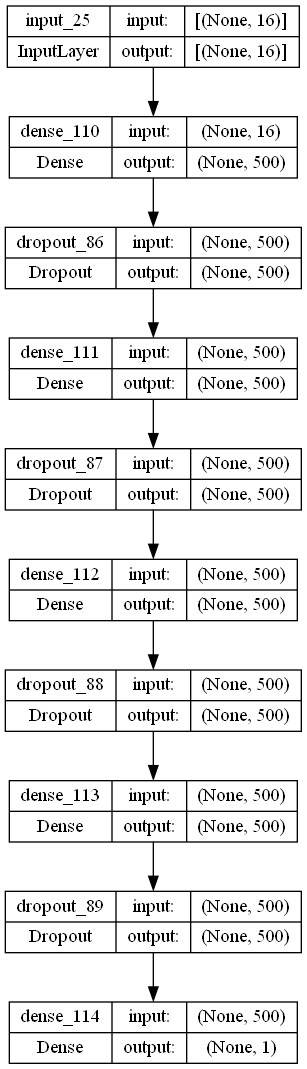

In [111]:
from kerastuner.engine.hyperparameters import HyperParameters
# best_hp = optimizer.get_best_hyperparameters()[0]
best_hp = HyperParameters()
best_hp.values = {'scale': 2, 'depth': 4, 'shape': 'linear', 'dropout': 0.5}
print(best_hp.values)
mlp_model = hypermodel(best_hp)
display(mlp_model.summary())
# plot model
plot_model(mlp_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

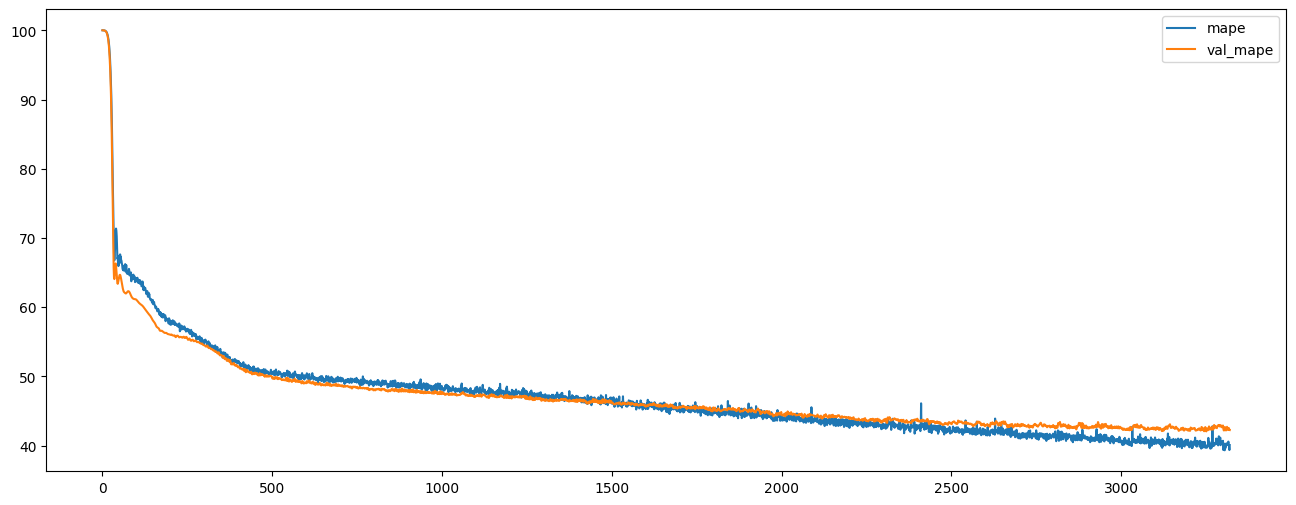

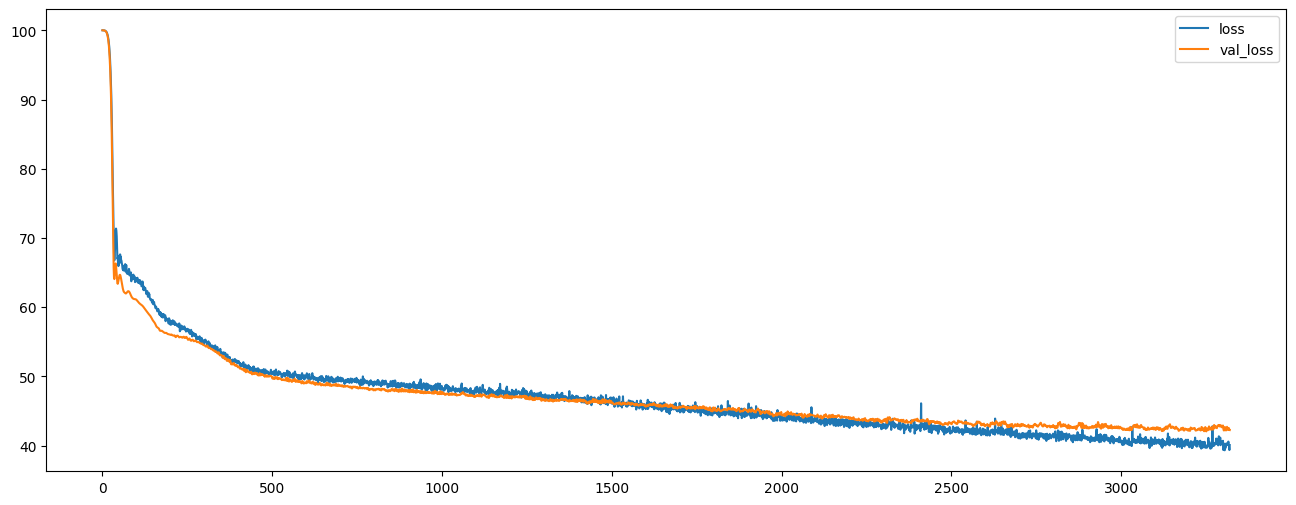

In [112]:
history = mlp_model.fit(
  features_train_nn,
  targets_train_nn,
  epochs=3500,
  batch_size=8000,
  validation_data=(features_val_nn, targets_val_nn),
  callbacks=[early_stopping], 
  verbose=0)
clear_output()
sns.lineplot(x=history.epoch, y=history.history['mean_absolute_percentage_error'], label='mape')
sns.lineplot(x=history.epoch, y=history.history['val_mean_absolute_percentage_error'], label='val_mape')
plt.show()
sns.lineplot(x=history.epoch, y=history.history['loss'], label='loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val_loss')
plt.show()

In [113]:
y = targets_train_nn
y_pred_val = mlp_model.predict(features_train_nn)
y_test = targets_test
y_pred = mlp_model.predict(data_test)
metrics = {
	'validation': {
		'mae': mean_absolute_error(y, y_pred_val),
		'rmse': np.sqrt(mean_squared_error(y, y_pred_val)),
		'median_error': median_absolute_error(y, y_pred_val),
		'r2': r2_score(y, y_pred_val),
		'mape': mean_absolute_percentage_error(y, y_pred_val),
		'gamma_deviance': mean_gamma_deviance(y, y_pred_val),
	},
	'test': {
		'mae': mean_absolute_error(y_test, y_pred),
		'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
		'median_error': median_absolute_error(y, y_pred_val),
		'r2': r2_score(y_test, y_pred),
		'mape': mean_absolute_percentage_error(y_test, y_pred),
		'gamma_deviance': mean_gamma_deviance(y_test, y_pred),
	}
}

validation = pd.DataFrame(metrics['validation'], index=['validation'])
test = pd.DataFrame(metrics['test'], index=['test'])
display(pd.concat([validation, test], axis=0).T)

model_mlp =  {
		'description': 'neural_network_mlp',
		'metrics': metrics,
		'estimator': mlp_model,
		'results': None,
		'predictions': y_pred,
	}

models[model_mlp['description']] = model_mlp

37/37 [==============================] - 0s 820us/step


,validation,test
mae,"47,794.1680","46,889.9492"
rmse,"143,325.6562","127,842.1094"
median_error,"8,593.4473","8,593.4473"
r2,0.3149,0.4165
mape,0.3662,0.4297
gamma_deviance,6.0869,1.5446


In [114]:
# salva o modelo
mlp_model.save('models/mlp_model.h5')

#### comparação de modelos

In [115]:
# plota a distribuição dos residuais
def plot_residuals_distribution (
		y_true: pd.DataFrame, 
		y_pred: pd.DataFrame, 
		title: str,
		pct: bool = False,
	) -> None:	
	if pct:
		y_pred = (y_pred - y_true)/y_true
	fig, axs = plt.subplot_mosaic([ ['R', 'R', 'R', 'D']],	figsize=(16, 6), constrained_layout=True, sharey=True)
	plt.suptitle(f"residuais {'percentuais ' if pct else ''}para {title}")
	plt.rcParams['figure.figsize'] = (16, 6)
	sns.residplot(x=y_true, y=y_pred, scatter_kws={'s':10, 'alpha':0.8, 'color':'grey'}, 
		lowess=True, line_kws={'lw':1, 'alpha': 1, 'color': 'red'}, label='prediction', ax=axs['R'])
	sns.distplot(y_pred, bins=20, kde=True, color='grey', label='prediction', ax=axs['D'], vertical=True)
	plt.xlabel('residuais')
	plt.ylabel('densidade')
	plt.legend()
	plt.show()

mae         rmse  median_error     r2  \
regression_tree_risk validation 41,021.2676 105,850.1567   11,139.5349 0.6218   
                     test       43,099.8999 102,567.1917   11,139.5349 0.6244   
random_forests_risk  validation 23,277.9308  63,693.5643    6,318.6839 0.8631   
                     test       33,004.7252  79,155.8967    6,318.6839 0.7763   
xgboost_dart_risk    validation 27,560.8887  74,632.8047    8,585.4570 0.8120   
                     test       32,985.0078  82,988.5078    8,585.4570 0.7541   
neural_network_mlp   validation 47,794.1680 143,325.6562    8,593.4473 0.3149   
                     test       46,889.9492 127,842.1094    8,593.4473 0.4165   

                                  mape  gamma_deviance  
regression_tree_risk validation 0.9244          0.3161  
                     test       0.7284          0.3637  
random_forests_risk  validation 0.8019          0.1399  
                     test       0.5648          0.2489  
xgboost_dart_risk    validation 0.6572          0.1793  
                     test       0.5124          0.2683  
neural_network_mlp   validation 0.3662          6.0869  
                     test       0.4297          1.5446

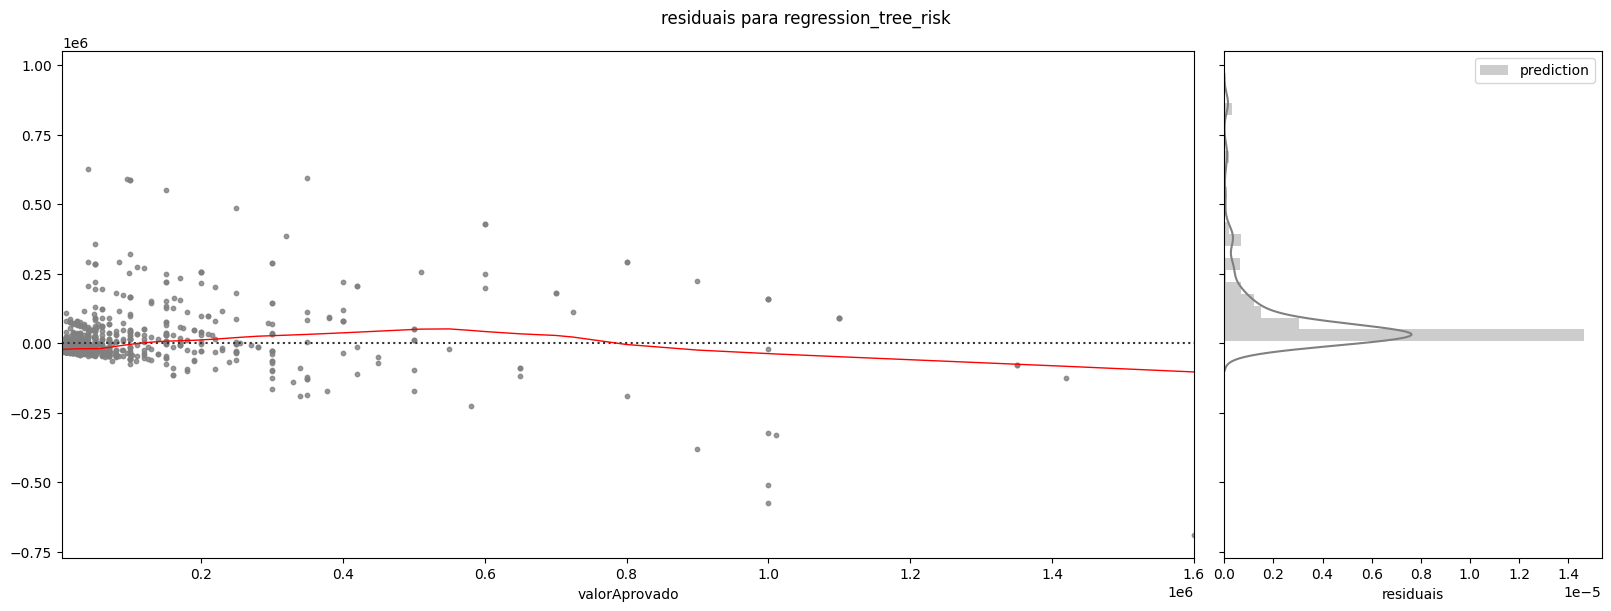

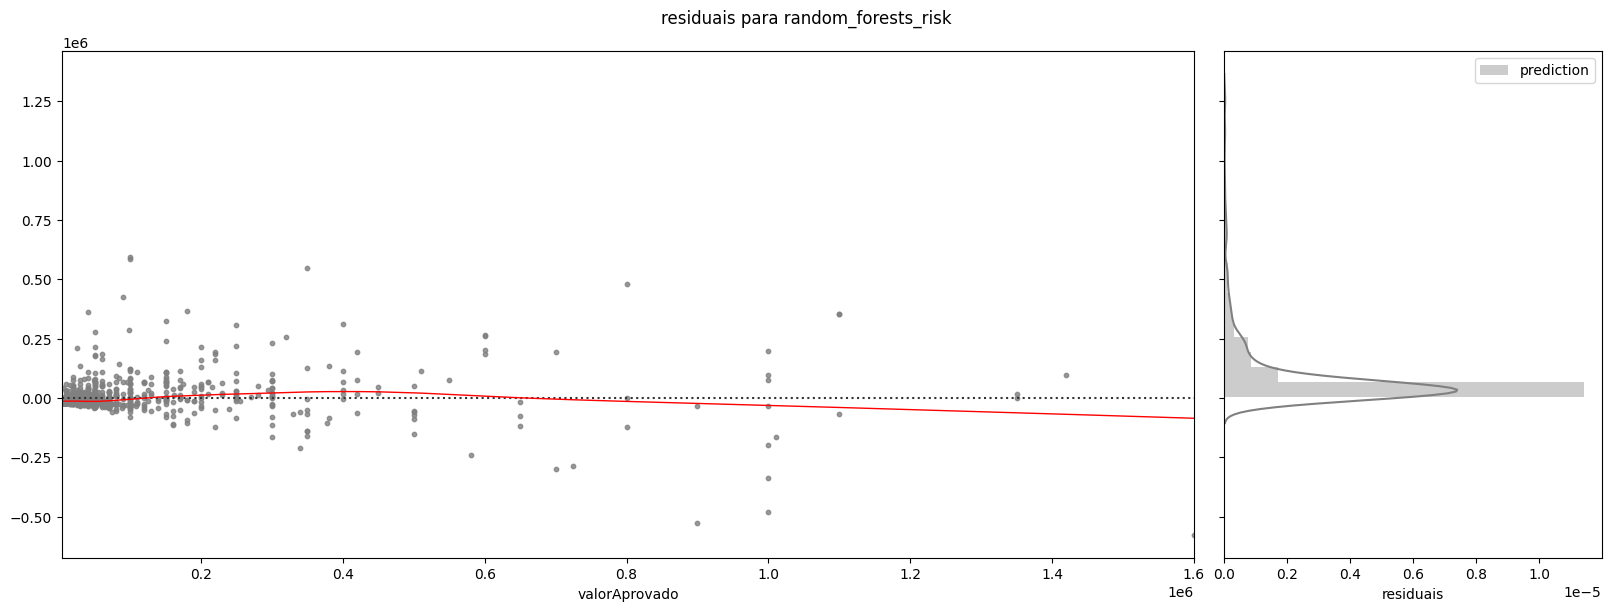

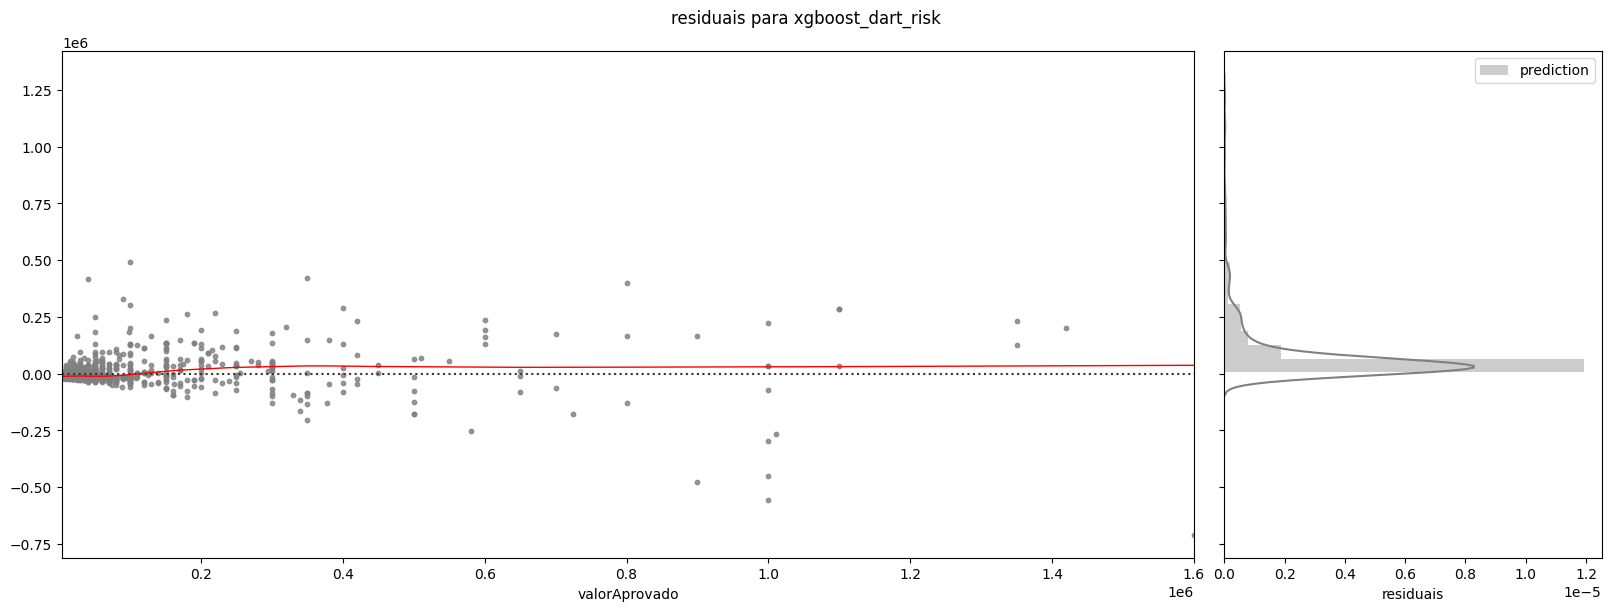

37/37 [==============================] - 0s 866us/step


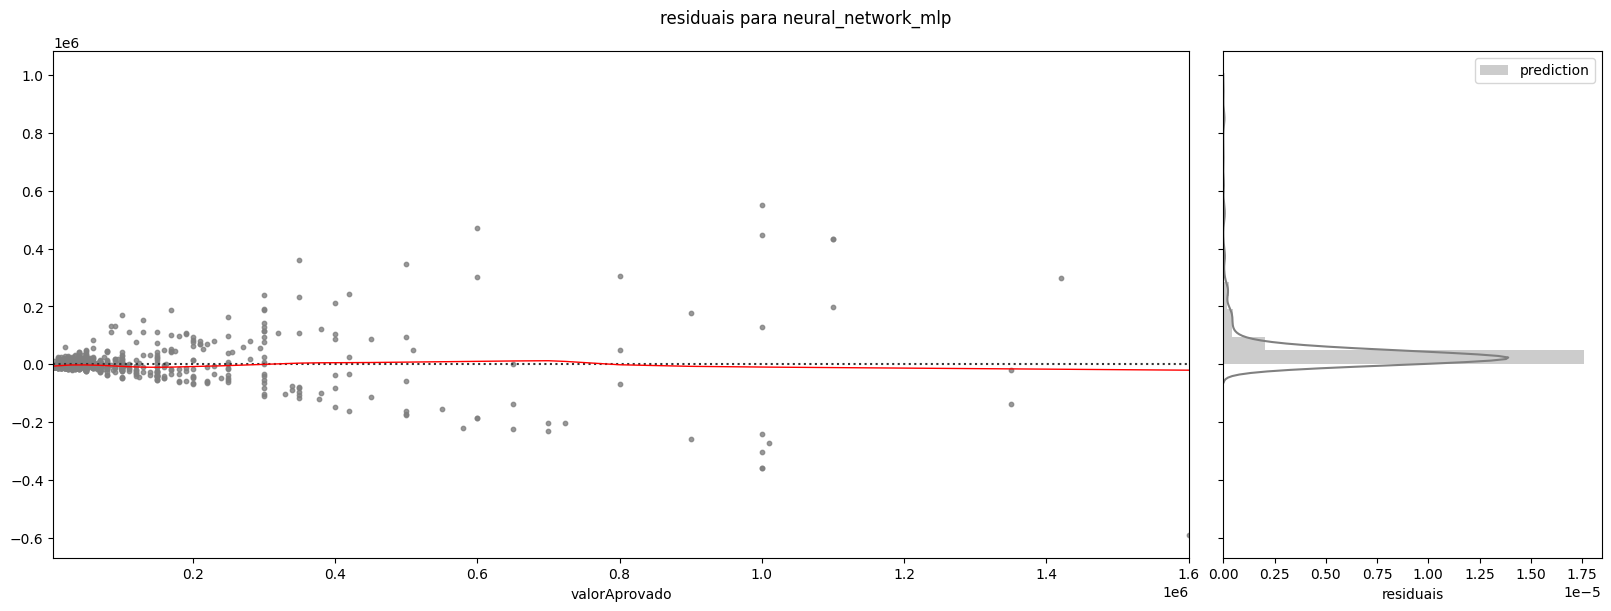

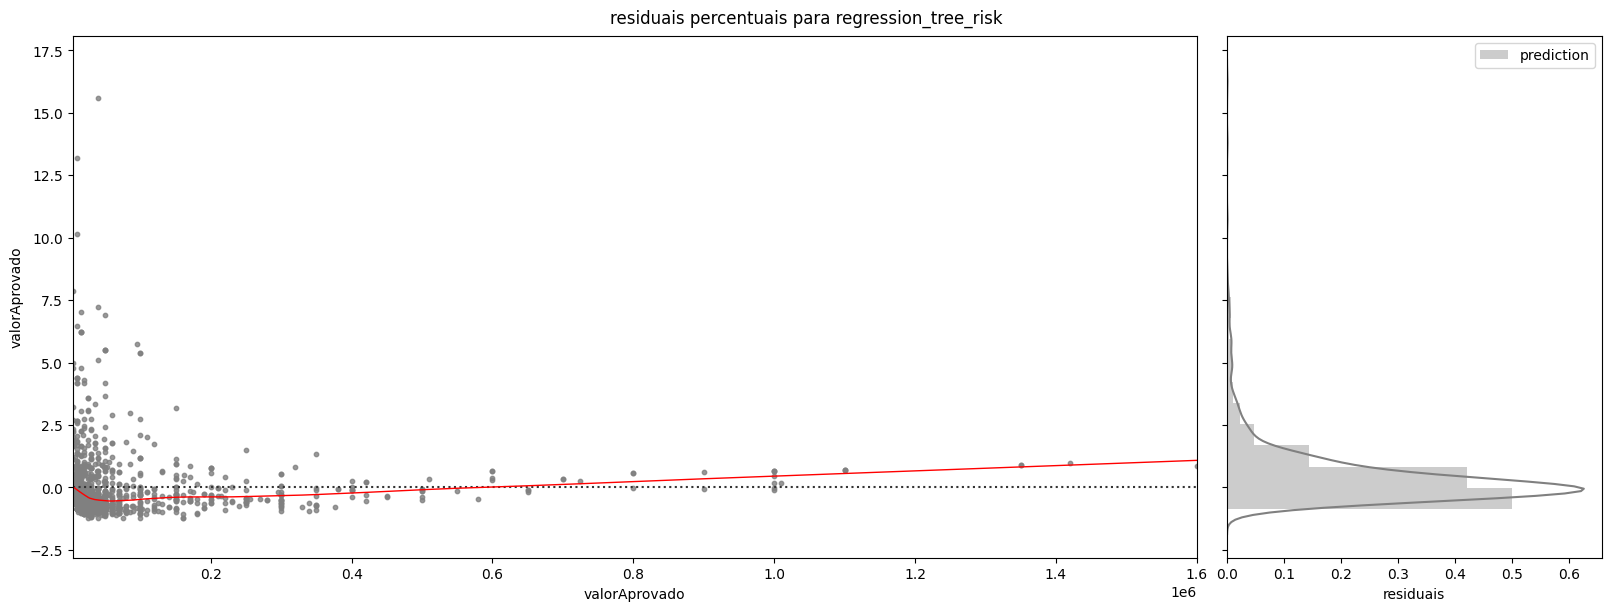

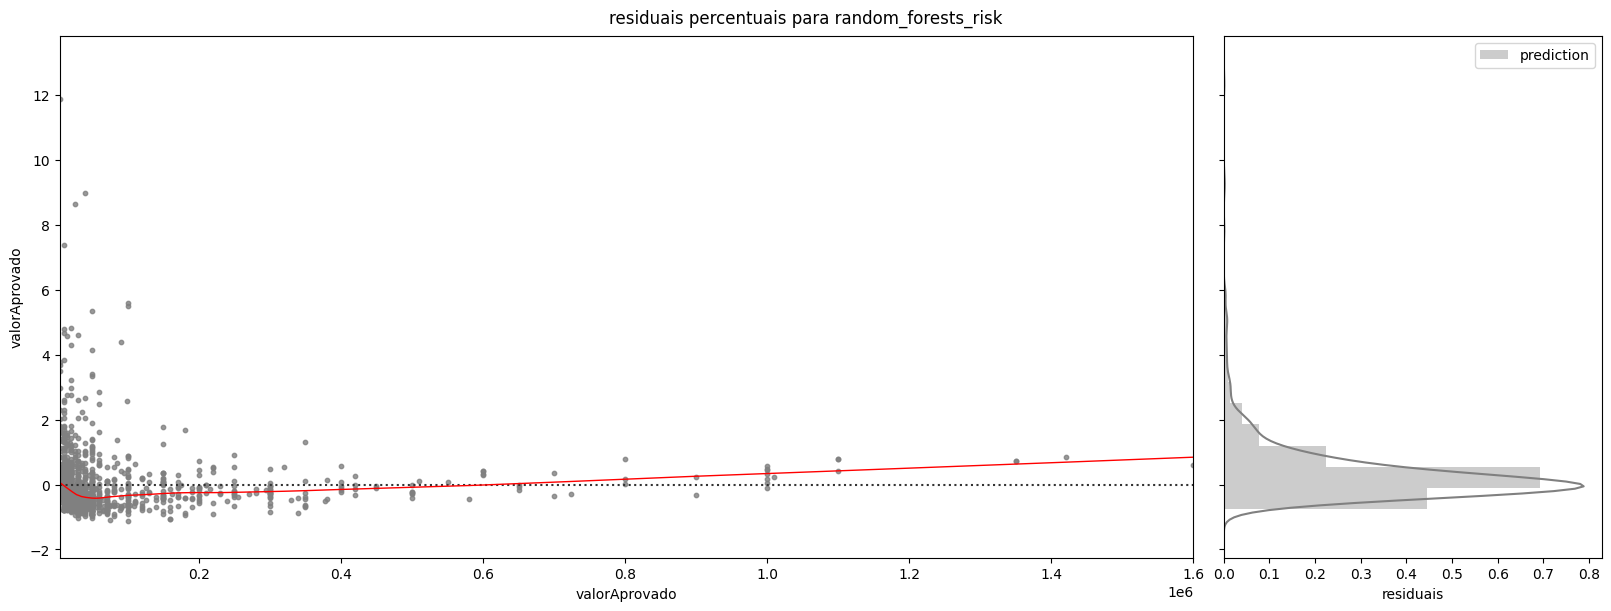

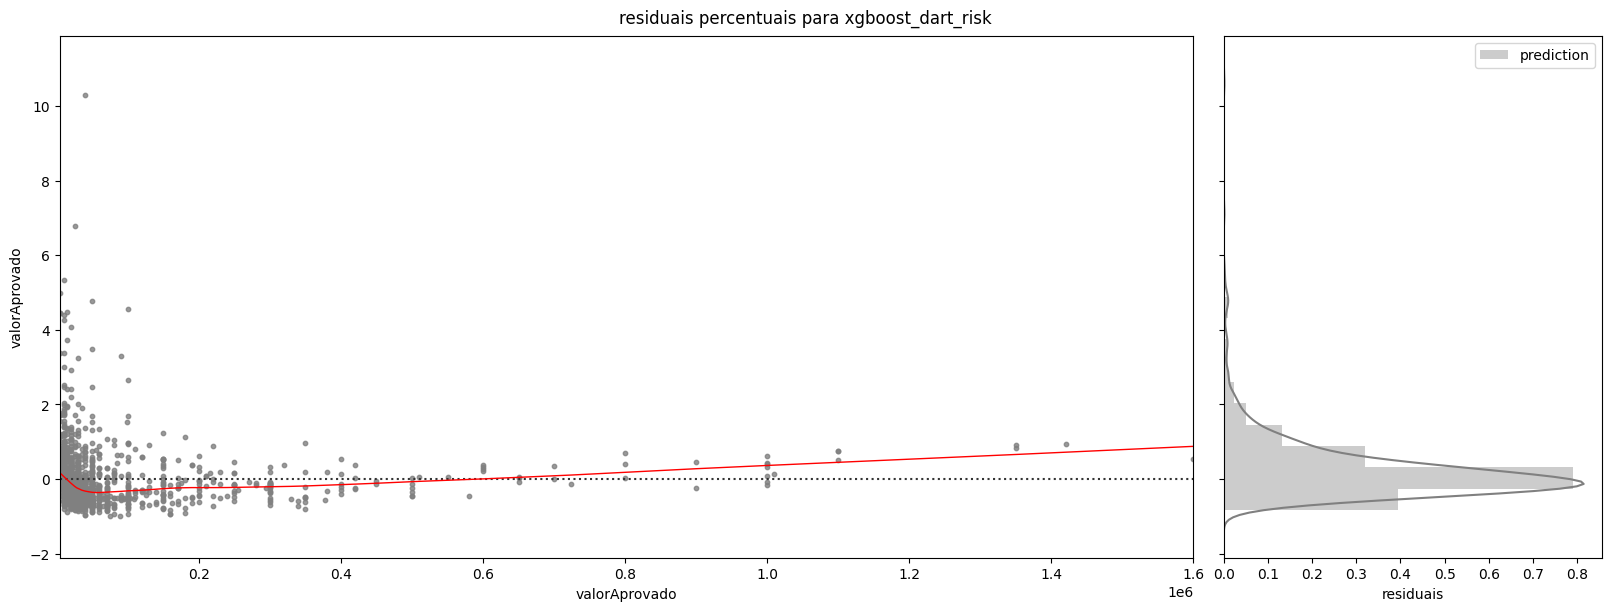

37/37 [==============================] - 0s 836us/step


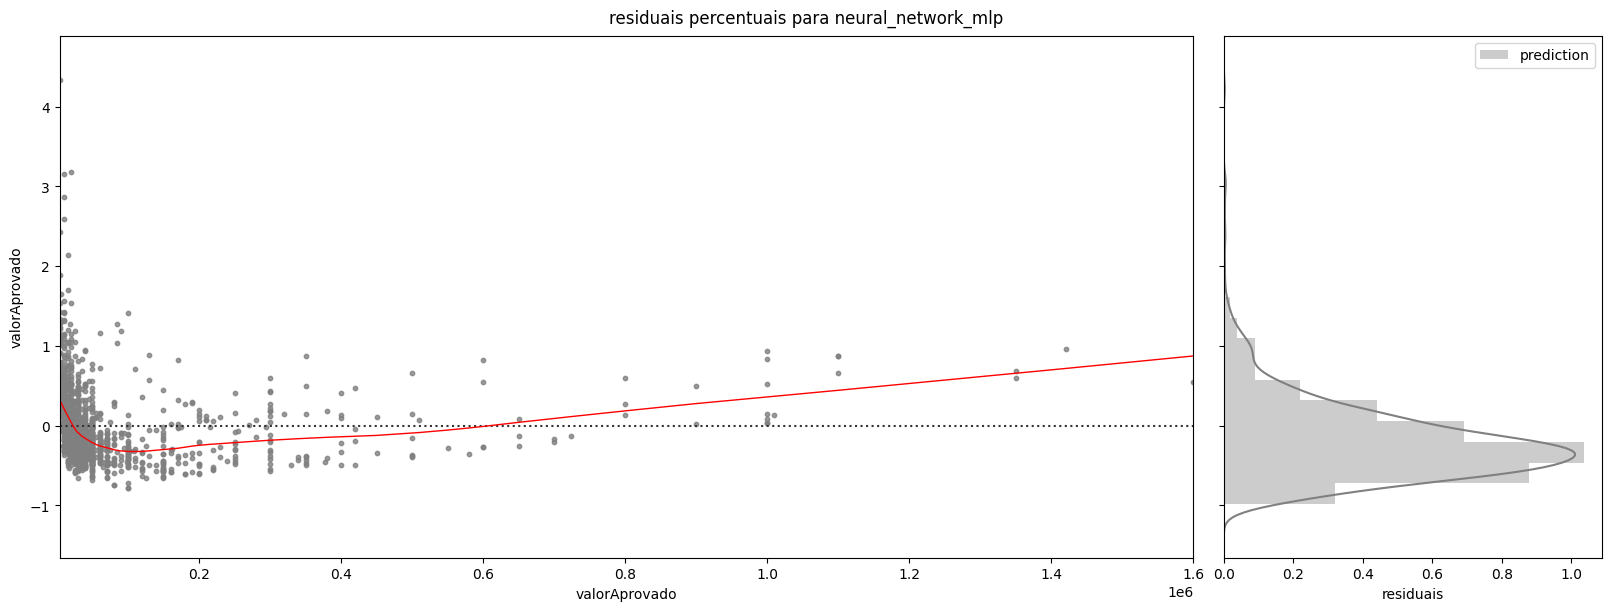

In [116]:
# compara os resultados entre os modelos
results = pd.DataFrame()
for model_name in models:
	model = models[model_name]
	validation = pd.DataFrame(model['metrics']['validation'], index=[[model['description']], ['validation']])
	test = pd.DataFrame(model['metrics']['test'], index=[[model['description']], ['test']])
	results = pd.concat([results, pd.concat([validation, test], axis=0)])

display (results)
# plota os graficos de residuais
for model_name in models:
	model = models[model_name]
	plot_residuals_distribution(targets_test, model['estimator'].predict(data_test).ravel(), title=model['description'])
	
for model_name in models:
	model = models[model_name]
	plot_residuals_distribution(targets_test, model['estimator'].predict(data_test).ravel(), title=model['description'], pct=True)


⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
A rede neural apresentou um MAPE de 42% na base teste e foi o modelo com melhor poder preditivo
</td></tr></table></div>

#### importância das features

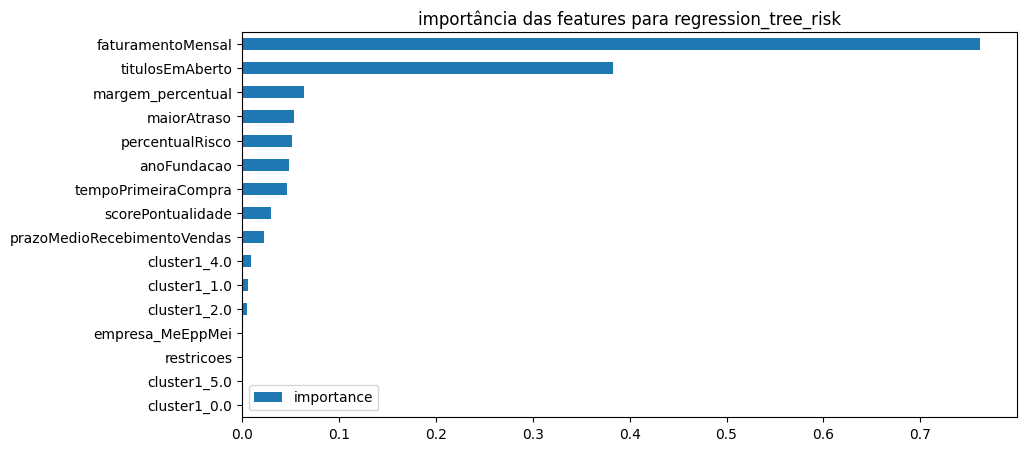

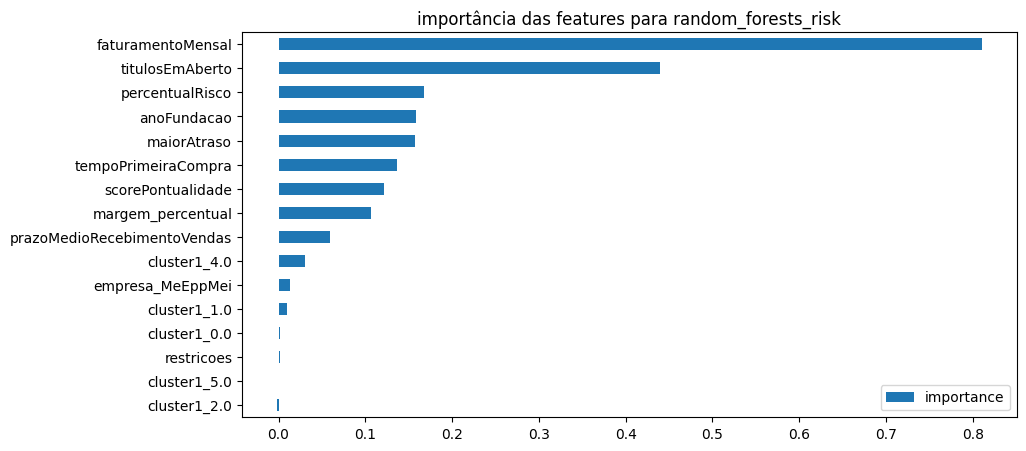

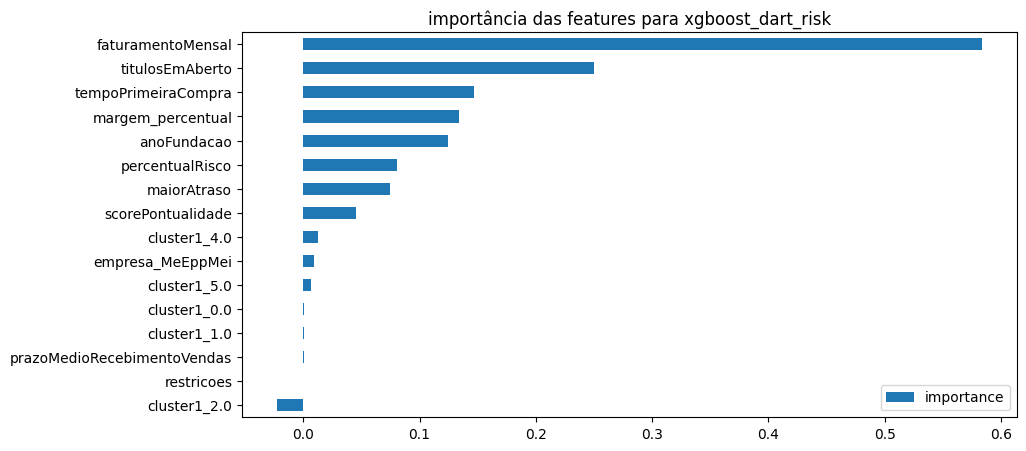

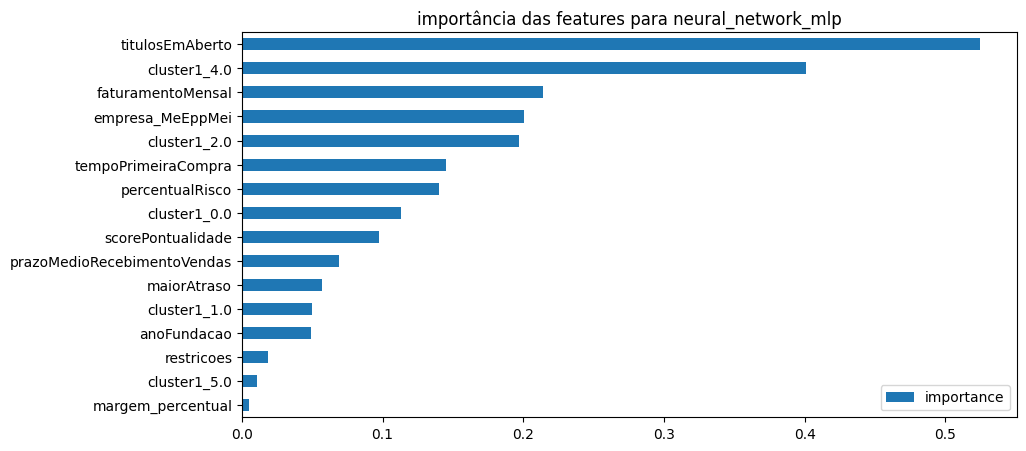

In [117]:
def plot_feature_importances(
		importances: pd.DataFrame,
		columns: list,
		) -> None:
	table = pd.DataFrame(importances.importances_mean, index=columns, columns=['importance'])
	table.sort_values(by='importance', ascending=True, inplace=True)
	table.plot.barh(figsize=(10, 3+int(table.shape[0]/6)))
	plt.title(f"importância das features para {model['description']}")
	plt.show()

for model_name in models:
	model = models[model_name]
	model['importances'] = permutation_importance(model['estimator'], data_train, targets_train, n_repeats=10, scoring='neg_mean_absolute_percentage_error')
clear_output()
for model_name in models:
	model = models[model_name]
	plot_feature_importances(importances=model['importances'], columns=data_train.columns)


### Conclusão

⭐ nota
<div style='color:#222200;background-color:#FFFFBB;padding:10px;'><table style='border:0px solid;width:100%'>
<tr><td style="border:0px;font-size:60px;width:80px;background-color:#FFFFBB">⭐</td><td style="border:0px;background-color:#FFFFBB;font-size:16px;">
- A rede neural performou bem e fez um bom aproveitamento das features para as predições <br>
- Outras conclusões...
</td></tr></table></div>